In [1]:
#!/usr/bin/env python
# coding: utf-8

import astropy.units as u
import numpy as np
import pytest

from plasmapy import simulation
from plasmapy.formulary import magnetostatics
from plasmapy.classes.sources import Coils
import matplotlib.pyplot as plt
import pyvista

MINOR_RADIUS = 0.3 * u.m
RADIUS = 1 * u.m
MAIN_CURRENT = 0 * u.MA

COIL_CURRENTS = 1 * [10 * u.MA]


coils = Coils.toykamak(MINOR_RADIUS, RADIUS, MAIN_CURRENT, COIL_CURRENTS)


x = u.Quantity([[1 + MINOR_RADIUS.si.value / 2, 0, 0]], u.m)
v = u.Quantity([[0, 100, 0]], u.m / u.s, dtype=float)

sim_single = simulation.ParticleTracker(coils, x, v, "e-")

In [2]:
sim_single.integrators

{'explicit_boris': CPUDispatcher(<function _boris_push at 0x7f3168906c10>),
 'implicit_boris': CPUDispatcher(<function _boris_push_implicit at 0x7f3168906dc0>),
 'implicit_boris2': CPUDispatcher(<function _boris_push_implicit2 at 0x7f3168906f70>),
 'zenitani': CPUDispatcher(<function _zenitani at 0x7f31689174c0>)}

explicit_boris
0.0004 0.0001


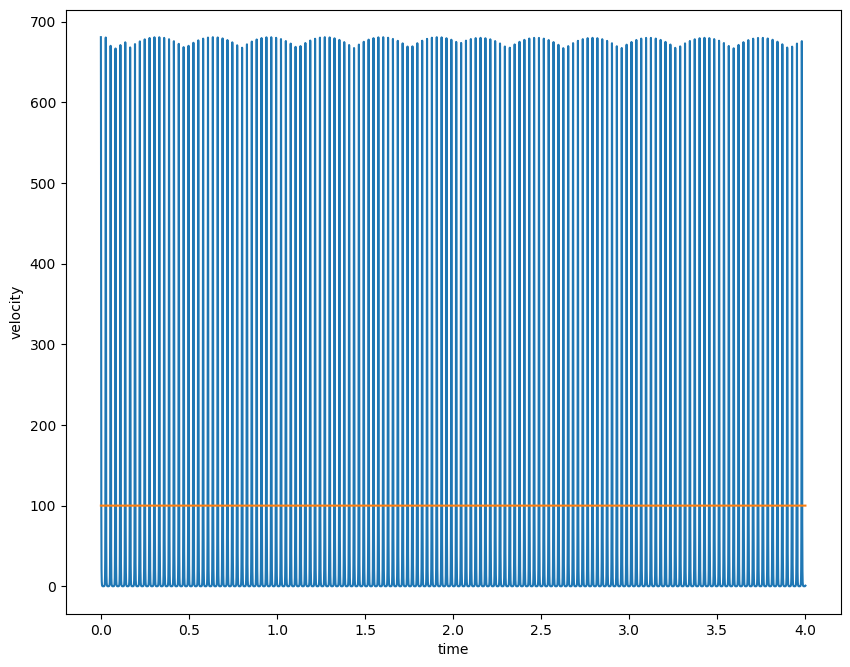

implicit_boris
0.0004 0.0001


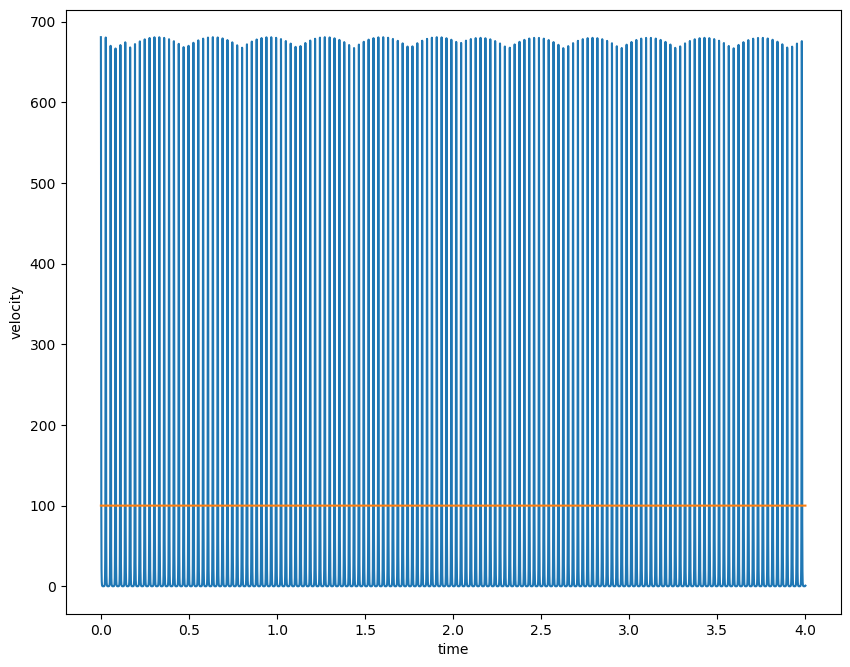

implicit_boris2
0.0004 0.0001


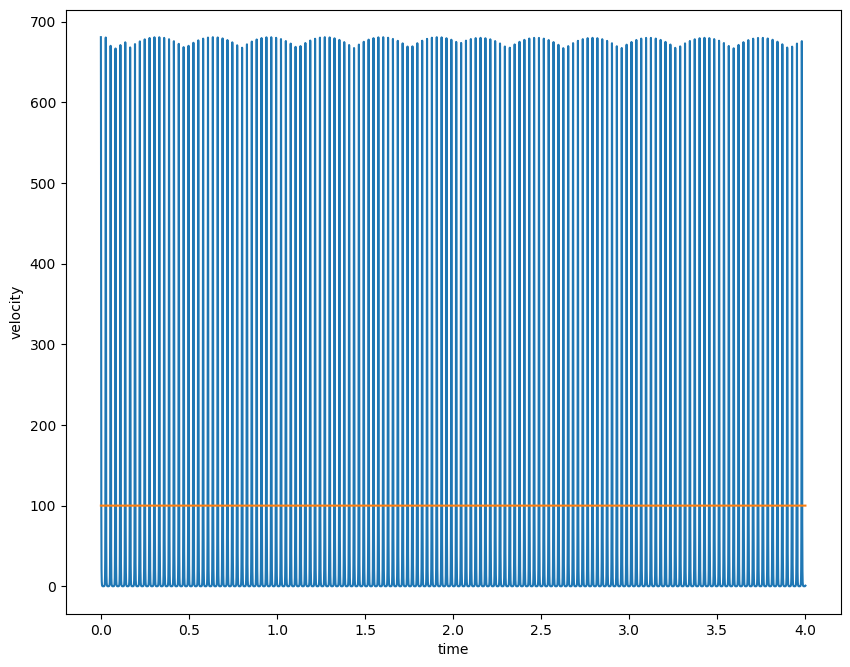

zenitani
0.0004 0.0001


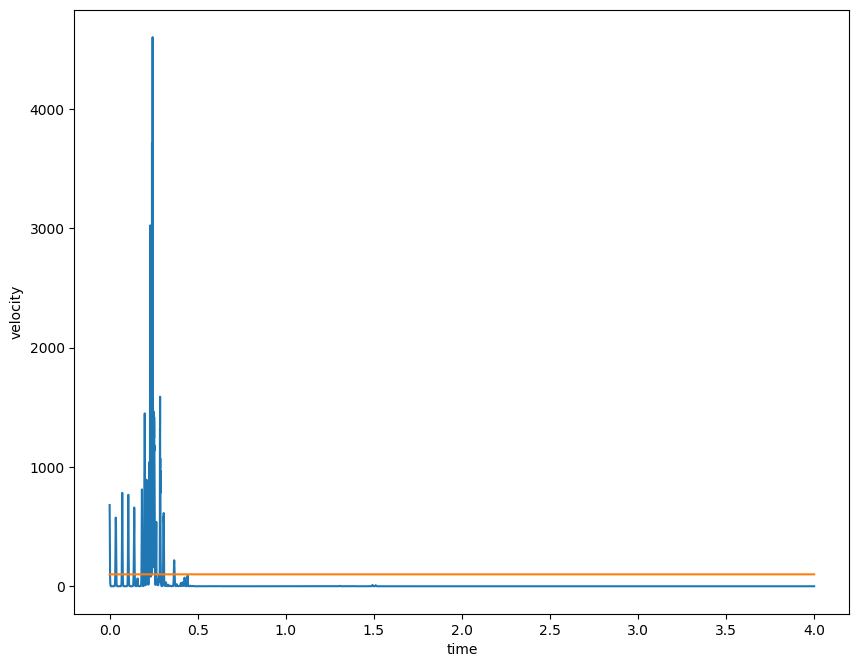

In [10]:
solutions = {}
for push in sim_single.integrators:
    print(push)
    solution = sim_single.run(4 * u.s, 1e-4 * u.s, snapshot_steps=10000, pusher=push)
    solutions[push] = solution
#     fig = pyvista.Plotter()
#     solution.visualize(fig)
#     fig.show()
    (solution.B**2).sum(dim=['particle','dimension']).plot.line()
    np.sqrt((solution.velocity**2).sum(dim=['particle','dimension'])).plot.line()
    plt.show()

In [11]:
solutions['explicit_boris']

<xarray.Dataset>
Dimensions:         (dimension: 3, particle: 1, time: 10001)
Coordinates:
  * time            (time) float64 0.0 0.0005 0.0008 0.0012 ... 3.999 4.0 4.0
  * particle        (particle) int64 0
  * dimension       (dimension) <U1 'x' 'y' 'z'
Data variables:
    position        (time, particle, dimension) float64 1.15 0.0 ... -7.928e-07
    velocity        (time, particle, dimension) float64 1.859e-14 ... -0.003063
    B               (time, particle, dimension) float64 2.425e-15 ... 6.677e-07
    E               (time, particle, dimension) float64 0.0 0.0 0.0 ... 0.0 0.0
    timestep        (time) float64 0.0001 0.0001 0.0001 ... 0.0001 0.0001 0.0001
    kinetic_energy  (time, particle) float64 4.555e-27 4.555e-27 ... 4.555e-27
Attributes:
    particle:          e-
    total_iterations:  40000

In [29]:
solution = solutions['explicit_boris']
solution.sizes['time']

10001

In [75]:
velocities #/ np.linalg.norm(velocities, axis=1)

array([[-7.32402596e+01,  6.80871822e+01, -1.53141796e-04]])

In [93]:
import pyvista as pv
import tqdm.auto as tqdm
particles = [0]
filename = "particles.mp4"

fig = pv.Plotter()
fig.open_movie(filename)
fig.write_frame()
nframes = 50
for i in tqdm.trange(1, nframes):
    fig.clear()
    coils.visualize(fig)
    frame_max = solution.sizes['time'] // nframes * i
    for particle in particles:
        trajectories = solution.position.sel(particle=particle).isel(time=range(0, frame_max)).values
        trajectory = pv.Spline(trajectories)
        fig.add_mesh(trajectory)
    
    points = solution.position.sel(particle=particles).isel(time=frame_max).values
    velocities = solution.velocity.sel(particle=particles).isel(time=frame_max).values
    point_cloud = pv.PolyData(points)
    point_cloud.abs_vel = np.linalg.norm(velocities, axis=1)
    point_cloud.vectors = velocities / (10 * point_cloud.abs_vel)
#     fig.add_mesh(point_cloud, show_scalar_bar = False)
    fig.add_mesh(point_cloud.arrows,  show_scalar_bar = False)
#     fig.show(auto_close = False)
    fig.write_frame()
fig.close()

In [94]:
from IPython.display import Video
Video("particles.mp4")

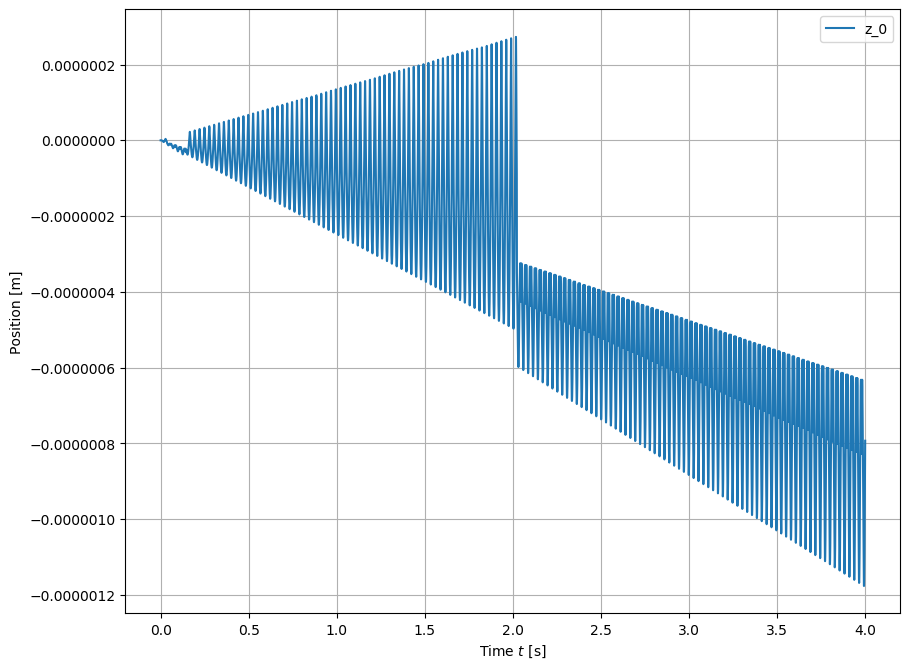

In [20]:
solutions['explicit_boris'].particletracker.plot_time_trajectories('z')

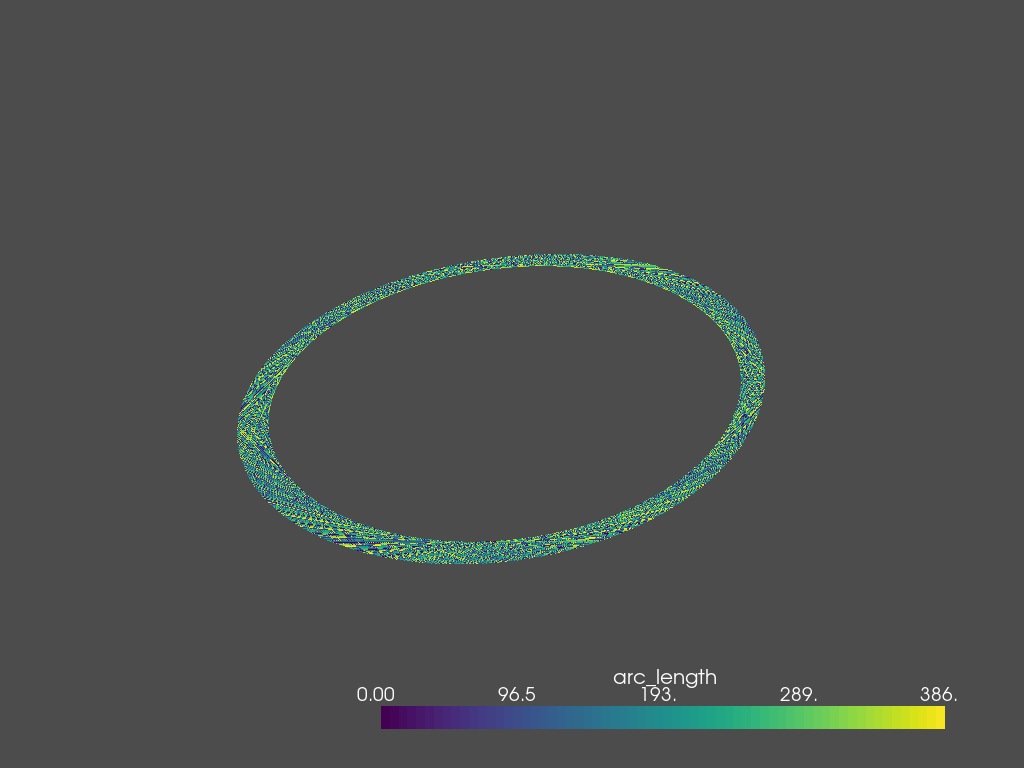

ERROR:root:The interactor must be set prior to enabling/disabling widget


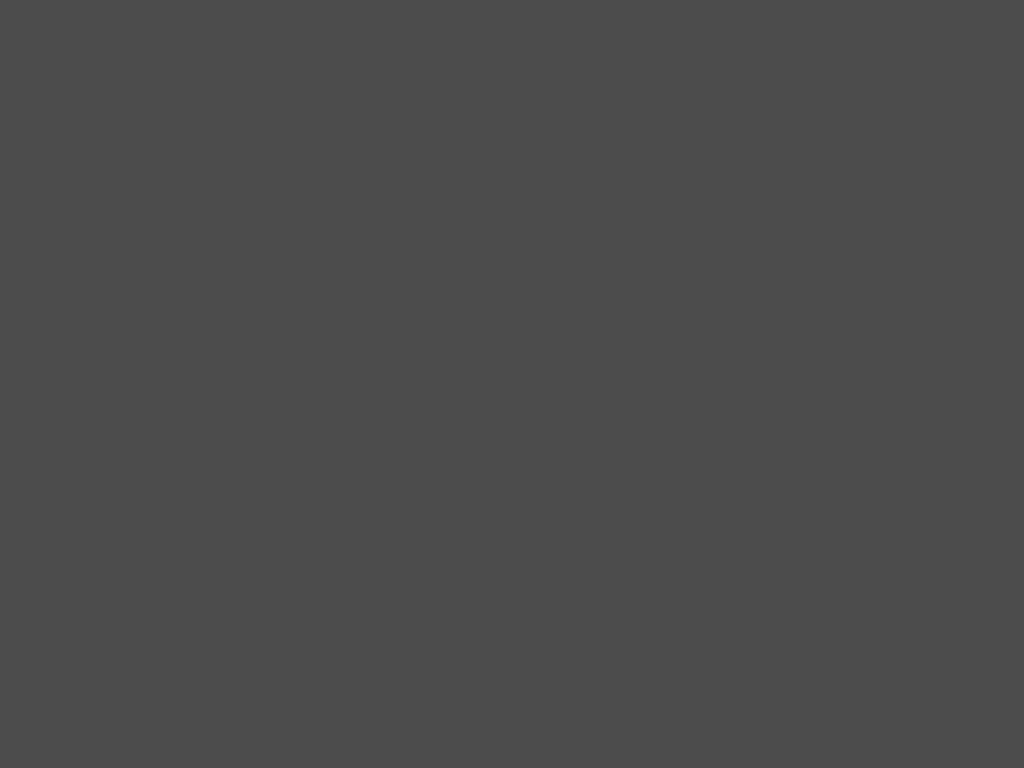

ERROR:root:The interactor must be set prior to enabling/disabling widget


In [13]:
solutions['explicit_boris'].particletracker.visualize()

In [ ]:
for solution in solutions:
    print(solution)
    solutions[solution].particletracker.plot_time_trajectories()

In [ ]:
for solution in solutions:
    print(solution)
    solutions[solution].particletracker.plot_time_trajectories('z')

In [ ]:
for solution in solutions:
    print(solution)
    solutions[solution].kinetic_energy.sel(particle=0).plot.line(x='time')
    print(solutions[solution].kinetic_energy.sel(particle=0).isel(time=-1) - solutions[solution].kinetic_energy.sel(particle=0).isel(time=0)) 

In [ ]:
solutions2 = {}
for push in ['explicit_boris', 'implicit_boris2']:
    solution = sim_single.run(400 * u.s, 1e-3 * u.s, pusher=push)
    solutions2[push] = solution
for name, solution in solutions2.items():
    print(name)
    (solution.data.B**2).sum(dim=['particle','dimension']).plot.line()
    plt.show()
    solution.kinetic_energy.sel(particle=0).plot.line(x='time')
    print(solution.kinetic_energy.sel(particle=0).isel(time=-1) - solution.kinetic_energy.sel(particle=0).isel(time=0)) 
    plt.show()
    solution.plot_trajectories()
    plt.show()

In [ ]:
for solution in solutions.values():
    solution.particletracker.plot_time_trajectories()
#     fig.show()

In [ ]:
solutions['explicit_boris'].

In [ ]:
for solution in solutions.values():
    fig = pyvista.Plotter()
    solution.particletracker.visualize(fig)
    fig.show()

In [ ]:
for push in ['zenitani']:
    print(push)
    solution = sim_single.run(0.04 * u.s, 1e-4 * u.s, pusher=push)
    fig = pyvista.Plotter()
    solution.visualize(fig)
    fig.show()
    (solution.data.B**2).sum(dim=['particle','dimension']).plot.line()
    plt.show()

In [ ]:
for solution in solutions:
    solutions[solution].data.position.sel(dimension='z', particle=0).plot(x='time', label=solution)
plt.legend()

In [ ]:
for solution in solutions:
    solutions[solution].data.velocity.sel(dimension='z', particle=0).plot(x='time', label=solution)
plt.legend()
plt.xlim(0, 0.05)

In [ ]:
for push in ['zenitani']:
    print(push)
    solution = sim_single.run(0.04 * u.s, 1e-4 * u.s, pusher=push)
    fig = pyvista.Plotter()
    solution.visualize(fig)
    fig.show()
    (solution.data.B**2).sum(dim=['particle','dimension']).plot.line()
    plt.show()
    (solution.data.position).sel(particle=0, dimension='y').plot.line()
    (solution.data.position).sel(particle=0, dimension='x').plot.line()
    plt.show()